In [1]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import time
import glob
import re
import nltk
from nltk.corpus import names
import nltk 
nltk.download('averaged_perceptron_tagger')
nltk.download('names')

from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn import svm
from sklearn.metrics import classification_report

from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [4]:
df = pd.read_csv("/content/sample_data/Racist_Sexist_Dataset.csv")

In [5]:
df.head()

,﻿id,tweet,class
0,5.720000e+17,So Drasko just said he was impressed the girls...,1
1,5.720000e+17,Drasko they didn&#39;t cook half a bird you id...,1
2,5.720000e+17,Hopefully someone cooks Drasko in the next ep ...,1
3,5.720000e+17,of course you were born in serbia...you&#39;re...,1
4,5.720000e+17,These girls are the equivalent of the irritati...,1


In [6]:
df.tail()

,﻿id,tweet,class
15943,5.760000e+17,credible reports that Iranian troops &amp; fig...,0
15944,5.760000e+17,RT BillSpindle: It&#39;s all about power at th...,0
15945,5.770000e+17,DEAR STATE DEPARTMENT: WHERE IS HILLARY CLINTO...,0
15946,5.610000e+17,@panelrific: Let&#39;s go üêßüêßüêßüêßüêß...,0
15947,5.690000e+17,üòÇ http://t.co/VQzuAXqNzd,0


In [7]:
df.describe()

,﻿id,class
count,1.594800e+04,15948.000000
mean,5.569026e+17,0.508904
std,3.775839e+16,0.798888
min,3.190000e+17,0.000000
25%,5.630000e+17,0.000000
50%,5.700000e+17,0.000000
75%,5.750000e+17,1.000000
max,6.850000e+17,2.000000


In [8]:
df.columns

Index(['﻿id', 'tweet', 'class'], dtype='object')

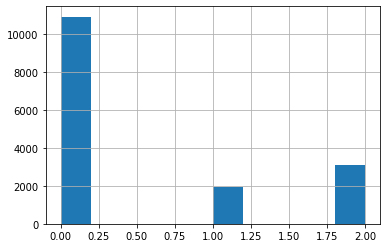

In [9]:
df['class'].hist()

In [10]:
tweets=df.tweet

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Feature Generation

In [13]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [15]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


In [16]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [17]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [18]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [21]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [22]:
feats = get_feature_array(tweets)

In [23]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [24]:
M.shape

(15948, 3777)

In [25]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

## Running the Model

In [26]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [27]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [28]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l2",C=0.01))
X_ = select.fit_transform(X,y)

In [29]:
model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_, y)

In [30]:
y_preds = model.predict(X_)

## Evaluating the results LinearSVC

In [31]:
report = classification_report( y, y_preds )

In [32]:
print(report)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88     10928
           1       0.64      0.93      0.76      1924
           2       0.78      0.68      0.73      3096

    accuracy                           0.84     15948
   macro avg       0.77      0.83      0.79     15948
weighted avg       0.85      0.84      0.84     15948



## Evaluating the results Logistic Regression (LR)

In [33]:
report = classification_report( y, y_preds )

In [34]:
print(report)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88     10928
           1       0.64      0.93      0.76      1924
           2       0.78      0.68      0.73      3096

    accuracy                           0.84     15948
   macro avg       0.77      0.83      0.79     15948
weighted avg       0.85      0.84      0.84     15948

